# 1. Imports

In [1]:
%matplotlib inline
import numpy as np
from sklearn import metrics

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sn
from captum.attr import visualization as viz, LayerAttribution, LayerGradCam

# Deep Learning frameworks
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import ResNet152_Weights
from transformers import (
    BitForImageClassification,
    BitImageProcessor,
    ViTForImageClassification,
    ViTImageProcessor,
)

# Data handling
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Import PyTorch and HuggingFace trainer classes from trainer.py
from trainer import PTTrainer, HFTrainer

2024-01-15 19:32:08.384496: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 19:32:08.400403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 19:32:08.400419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 19:32:08.400882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 19:32:08.403722: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(f"The device used for heavy computations is the {torch.cuda.get_device_name(0)}.")

The device used for heavy computations is the NVIDIA GeForce RTX 3090 Ti.


# 2. Data
The ImageFolder allows to create a dataset from a directory, where the subdirectories each contain images that are labeled by the name of the subdir.
The train set is then split into a train and validation set to monitor the training progress on untrained data. It allows using an early stopping callback that stops training after the validation loss has not decreased for a while.

In [3]:
train_folder = ImageFolder(root="./train")
val_folder = ImageFolder(root="./train")
test_set = ImageFolder(root="./test")

generator = torch.Generator().manual_seed(1)
train_set, val_set = torch.utils.data.random_split(train_folder, [0.9,0.1], generator=generator)
val_set.dataset = val_folder # Necessary to apply other image transformations (without augmentations) than to train set.

### Dataset statistics
About the distribution and amount of classes

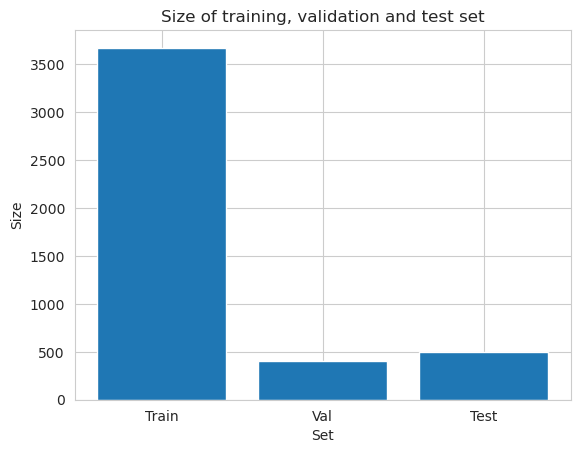

In [4]:
plt.bar(["Train", "Val", "Test"], [len(train_set), len(val_set), len(test_set)])
plt.xlabel("Set")
plt.ylabel("Size")
plt.title("Size of training, validation and test set")
plt.show()

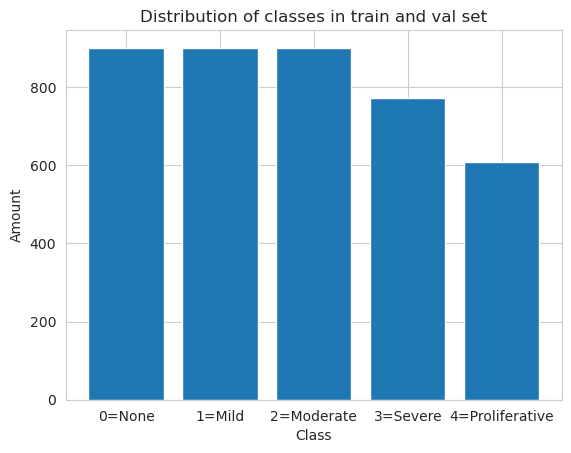

In [5]:
img_label = np.array(train_set.dataset.imgs)
classes = ["0=None", "1=Mild", "2=Moderate", "3=Severe", "4=Proliferative"]
plt.bar(classes, [len(img_label[img_label[:,1] == str(i)]) for i in train_set.dataset.classes])
plt.xlabel("Class")
plt.ylabel("Amount")
plt.title("Distribution of classes in train and val set")
plt.show()

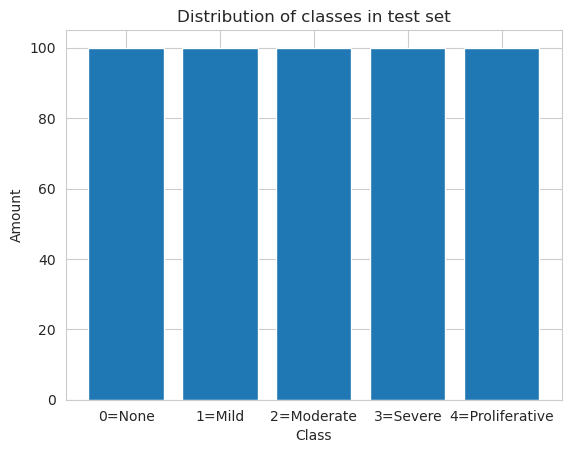

In [6]:
img_label = np.array(test_set.imgs)

plt.bar(classes, [len(img_label[img_label[:,1] == str(i)]) for i in test_set.classes])
plt.xlabel("Class")
plt.ylabel("Amount")
plt.title("Distribution of classes in test set")
plt.show()

### Augmenting the Data
Here, the training data is being augmented in order to increase the training set size which avoids too early overfitting.
Also, the images are brought into the correct shape and value range required by the models that are used. Fortunately, these are the same for all three models used.
These augmentations will be newly applied every time an image is requested by a model. So every epoch, the models will train on slight variations of the same images. Therefore, augmenting images is a technique to deal with little data, as there are seemingly endless ways to generate new images which increases training set size.
The set of augmentations are highly optimized and adding more or different augmentations made the classification results worse for all three models.

In [7]:
# Transforms for the train set that augments the data
transform_train = transforms.Compose([
    transforms.Resize((1024, 1024), antialias=True),
    transforms.RandomRotation((-35, 35)), # First rotate then crop to remove black corners introduced by rotating the image
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=.2), # Some images are naturally darker, and some lighter. So augmenting the brightness improves results
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True), # Required size for all three models used
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Required pixel range for all three models
])

# Transforms for the validation and test set.
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024), antialias=True),
    transforms.CenterCrop(size=(900, 900)),
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply these transforms to the datasets
train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val
test_set.transform=transform_val

# Create a DataLoader
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=generator)

### Plotting augmented example images

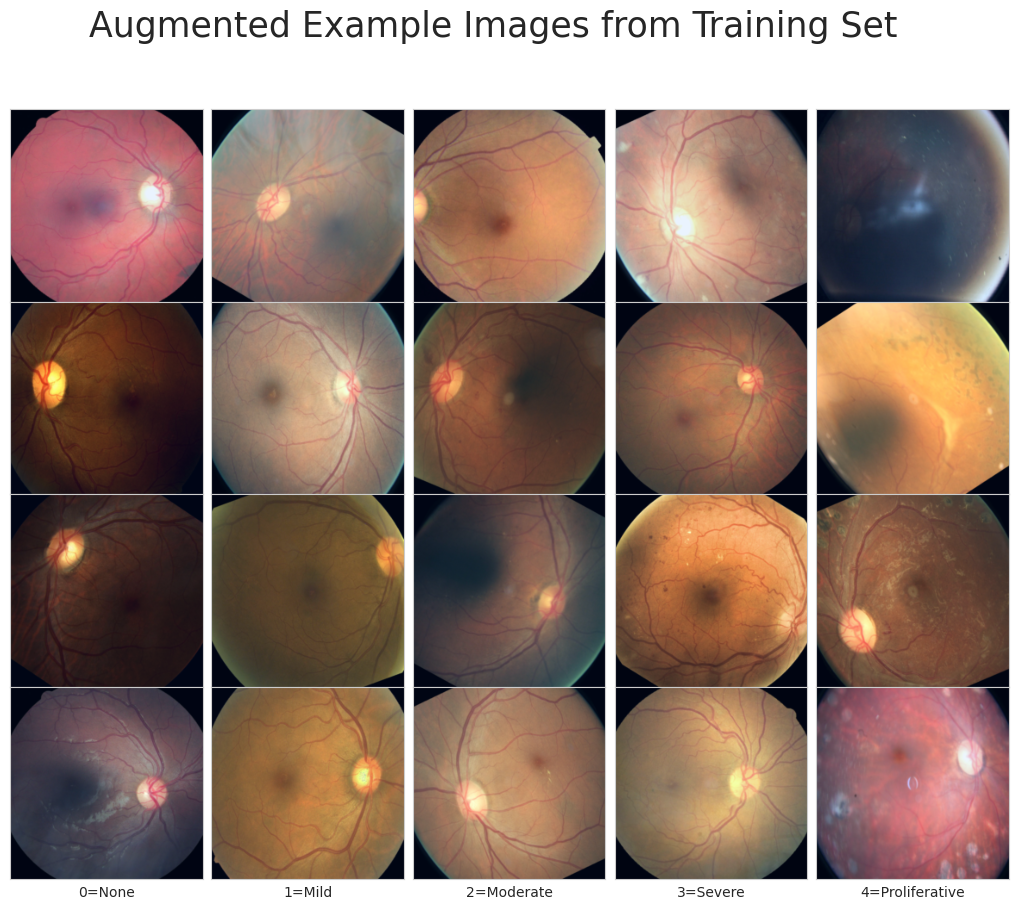

In [8]:
figs, axs = plt.subplots(4,5, figsize=(13, 10))
figs.subplots_adjust(wspace=0, hspace=0)

axs=axs.flatten()
counter = 0
for inputs, labels in train_loader:
    if counter < 20:
        for j in range(len(inputs)):
            if counter < 20:
                if labels[j] == counter%5:
                    img = np.array(inputs[j].permute(1, 2, 0))
                    img = (img - img.min()) / (img.max() - img.min())
                    axs[counter].imshow(img)
                    if counter > 14:
                        axs[counter].set_xlabel(classes[counter%5])
                    counter += 1
                    
            else:
                break
    else:
        break
for ax in axs:
    ax.grid(False)
    ax.tick_params(labelbottom=False, labelleft=False)
plt.suptitle("Augmented Example Images from Training Set", fontsize=25)
plt.show()

# 3. Plotting functions
Now a few plotting functions are defined that ideally work for all three models. Only the visualization of the attention maps works differently for CNNs and transformers.

In [50]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    axs = axs.flatten()
    axs[0].set_title("Accuracy")
    axs[1].set_title("Loss")
    for i, (set, metric) in enumerate([["Train", "accuracy"], ["Test", "accuracy"], ["Train", "loss"], ["Test", "loss"]]):
        if len(history[i]) > 0:
            axs[int(i/2)].plot(history[i], label=f"{set} {metric}")
        axs[int(i/2)].set_xlabel("Epoch")
        if int(i/2) == 0:
            axs[int(i/2)].set_ylabel("Accuracy")
        else:
            axs[int(i/2)].set_ylabel("Error")
        if len(history[i]) > 0:
            axs[int(i/2)].legend()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(model_trainer, model_name):
    true_classes, pred_classes = model_trainer.validate(test_loader=test_loader, device="cuda")
    ax = sn.heatmap(metrics.confusion_matrix(true_classes, pred_classes), annot=True, cmap="Blues", fmt='g')
    ax.set(xlabel="Predicted Class", ylabel="True Class")
    ax.set_title(f"{model_name} \nAcc: {round(metrics.accuracy_score(true_classes, pred_classes), 2)}, F1: {round(metrics.f1_score(true_classes, pred_classes, average='macro'), 2)}", fontsize=20)
    plt.show()
    return true_classes, pred_classes

In [11]:
def plot_misclassified(true_classes, pred_classes):
    missclassified_ids = []
    for true_class in range(5):
        missclassified_ids.append(np.where(((np.array(true_classes)!=np.array(pred_classes)) & (np.array(true_classes) == true_class)) == True)[0][0])
    misclassified_imgs = np.array(test_set.imgs)[np.array(missclassified_ids)]
    misclassified_imgs = np.concatenate([misclassified_imgs, np.array(pred_classes)[missclassified_ids].reshape(-1,1)], axis=1)

    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, (path, true_class, pred_class) in enumerate(misclassified_imgs):
        # Load and plot the misclassified image
        img = Image.open(path)

        axs[i].imshow(img)
        axs[i].set_title(f'True: {true_class}\nPred: {pred_class}')
        axs[i].axis('off')
    plt.show()

In [12]:
def plot_attention_cnn(cnn_model, conv_layer_index):
    cnn_model = cnn_model.to("cpu")
    conv_layers = [module for module in cnn_model.modules() if isinstance(module, torch.nn.Conv2d)]
    target_layer = conv_layers[conv_layer_index]
    
    layer_gradcam = LayerGradCam(cnn_model, target_layer)
    
    for img_path in ["test/4/1084_right.jpeg", "test/3/1471_right.jpeg", "test/2/1527_left.jpeg", "test/1/1540_right.jpeg", "test/0/1070_left.jpeg"]:
        img = Image.open(img_path)
        img_transform = transform_val(img)
        attributions_lgc = layer_gradcam.attribute(img_transform.unsqueeze(0), target=[eval(img_path[5])])
        upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, img_transform.shape[1:])
        
        print("True class:", img_path[5])
        print("Predicted class:", int(torch.argmax(cnn_model(img_transform.unsqueeze(0)))))
        _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                              np.array(img.resize((224, 224))),
                                              ["original_image","heat_map","masked_image"],
                                              ["all","absolute_value","absolute_value"],
                                              show_colorbar=True,
                                              titles=["Original","Heat Map",  "Masked"],
                                              fig_size=(18, 6), cmap="RdBu_r")

In [13]:
def plot_attention_vit(vit_model, layer=-1, head=0, mask_threshold=0.01):
    for img_path in ["test/4/1084_right.jpeg", "test/3/1471_right.jpeg", "test/2/1527_left.jpeg", "test/1/1540_right.jpeg", "test/0/1070_left.jpeg"]:
        img = Image.open(img_path)
        transformed_img = transform_val(img).unsqueeze(0).to("cuda")

        # Get attention maps
        output = vit_model(transformed_img, output_attentions=True, interpolate_pos_encoding=True)
        attentions = output.attentions[layer]
        
        # keep only the output patch attention
        attentions = attentions[0, head, 0, 1:].unsqueeze(0)
        
        w_featmap = transformed_img.shape[-2] // vit_model.config.patch_size
        h_featmap = transformed_img.shape[-1] // vit_model.config.patch_size
        
        attentions = attentions.reshape(1, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=vit_model.config.patch_size, mode="nearest")[0].cpu()
        attentions = attentions.detach().numpy()
        
        # Apply attention mask to the image
        masked_img = np.array(img.resize([224,224]))
        masked_img[ attentions[0] < mask_threshold] = 0  # mask areas with attention below threshold
        
        print(f"Predicted class {int(torch.argmax(output.logits))}")
        print(f"True class {img_path[5]}")

        plt.figure(figsize=(18, 6))
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(img.resize([224,224]))
        plt.title('Original Image')
        plt.grid(False)
        plt.tick_params(labelbottom=False, labelleft=False)
        # Plot attention map
        plt.subplot(1, 3, 2)
        plt.imshow(attentions[0], cmap="RdBu_r")
        plt.title(f'Attention Map - Head {head}')
        plt.grid(False)
        plt.tick_params(labelbottom=False, labelleft=False)
        # Plot masked image
        plt.subplot(1, 3, 3)
        plt.imshow(masked_img)
        plt.title(f'Masked Image - Head {head}')
        plt.grid(False)
        plt.tick_params(labelbottom=False, labelleft=False)
        plt.show()


# 4.1 ResNet152V2
This CNN was picked, as it is one of the largest models that can efficiently train on the RTX 3090ti without any efficiency limitations. And larger means most of the time better.
Also, it will be possible to compare it to the Big Transfer model which also has the Resnet152V2 as a backbone.
## Training

In [14]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# Modify the output layer to match the number of classes in the dataset and reset the weights for transfer learning
num_classes = len(train_set.dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

resnet = PTTrainer(model) # Instantiate a new PyTorch trainer specified in trainer.py

resnet_history = resnet.train(train_loader=train_loader,
             val_loader=val_loader,
             epochs=30, #  Maximum number of epochs.Early stopping likely stops training before epoch 30 is reached.
             lr=0.001,
             device="cuda", #  Train on the GPU
             patience=5, #  Early stopping patience
             log=True)

Epoch 0 running
Train Acc: 40.87% Loss: 1.28 Time: 89s
Validation Acc: 37.05% Loss: 1.34 Time: 96s
Epoch 1 running
Train Acc: 46.79% Loss: 1.17 Time: 182s
Validation Acc: 39.29% Loss: 1.29 Time: 189s
Epoch 2 running
Train Acc: 48.63% Loss: 1.14 Time: 277s
Validation Acc: 39.73% Loss: 1.33 Time: 283s
Epoch 3 running
Train Acc: 50.11% Loss: 1.10 Time: 371s
Validation Acc: 46.21% Loss: 1.14 Time: 378s
Epoch 4 running
Train Acc: 52.07% Loss: 1.06 Time: 465s
Validation Acc: 45.54% Loss: 1.17 Time: 472s
Epoch 5 running
Train Acc: 52.61% Loss: 1.04 Time: 560s
Validation Acc: 45.76% Loss: 1.16 Time: 566s
Epoch 6 running
Train Acc: 54.15% Loss: 1.00 Time: 653s
Validation Acc: 39.73% Loss: 1.33 Time: 659s
Epoch 7 running
Train Acc: 55.50% Loss: 0.98 Time: 746s
Validation Acc: 43.08% Loss: 1.17 Time: 752s
Epoch 8 running
Train Acc: 56.79% Loss: 0.97 Time: 839s
Validation Acc: 42.86% Loss: 1.22 Time: 845s


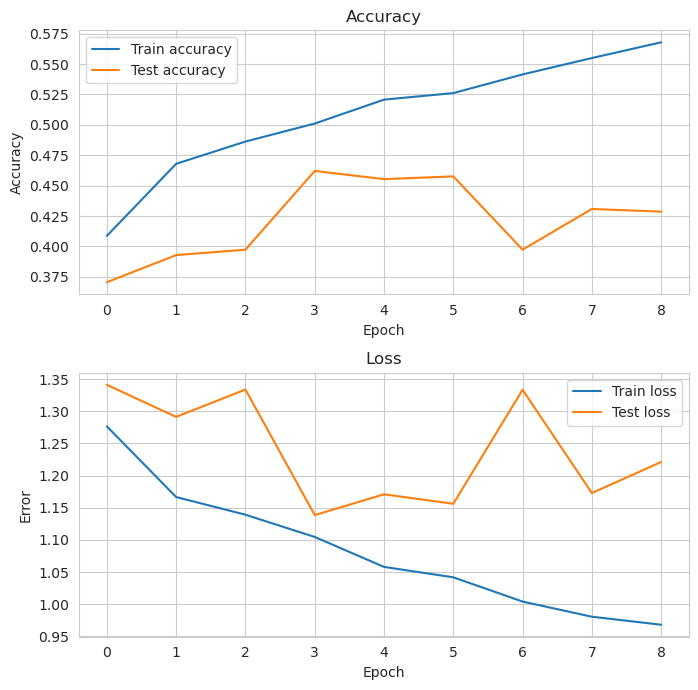

In [52]:
plot_history(resnet_history)

The training history looks like it is expected. The test loss decreases within the first few epochs and has a local minima at epoch 3. After that, it increases again and training stops five epochs later like it was specified by the early stopping patience of five. The training error continuously decreases as the model starts to overfit to the training dataset. The accuracies behave similarly than the error, just that they are mirrored.

## Evaluation
The model will be evaluated using the confusion matrix, the accuracy and the f1-score. Also the average inference time per image will be printed.

Avergae inference time per image is 16ms on the device NVIDIA GeForce RTX 3090 Ti.


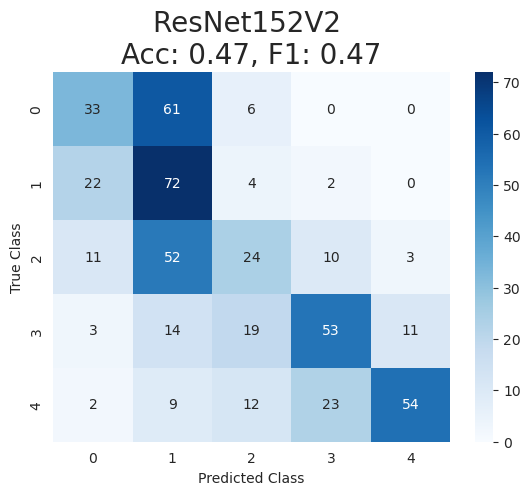

In [16]:
resnet_labels, resnet_preds = plot_confusion_matrix(resnet, "ResNet152V2")

The confusion matrix suggests that the model can confidently detect classes 3 and 4 but struggles to sperate classes 0 to 2 and chooses most of the time class 1.
This does make sense considering that diabetic retinopathy classes represent a scale from 0 to 4 and are not mutually exclusive.

## Misclassified Images
Here, images are plotted that were not correctly classified by the model. For each image, the correct label and the prediction of the model will be presented.

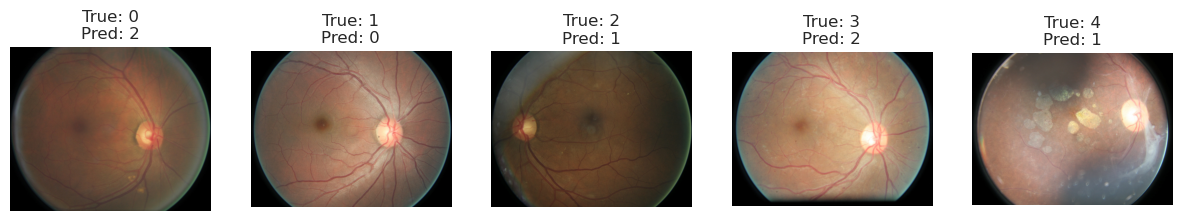

In [17]:
plot_misclassified(resnet_labels, resnet_preds) 

What stands out is the fifth image which contains clearly visible hard exudates which were probably missed by the model. This theory is supported by the fact that the model also did not focus on the hard exudates in the first image in the next section about model Explainability.
Besides that, the model seems to only miss-classify images by one or two classes in the other four cases.
Reasons for this might be that, since the classes represent a scale,
someone would have to put each image into one class to create this dataset and due to the size of the dataset,
it is more likely that not only one person has labeled the whole dataset, but a group of people. 
Then, different people would probably label the same image differently because everyone interprets the biomarkers differently.
There is no objective way to label these images, and if there would be one, a classifier would not be needed.
The model can only be as good as the people that labeled the dataset, therefore, it does the same mistake of miss-classifying some images by one or two classes.

## Explainability
To explain the decision the model has made, the gradients from the convolution layers of the ResNet are extracted, visualized and plotted over the original image using the GradCam.
These gradients can be interpreted as heatmaps. Areas of the image that influenced the model the most are visualized in red and uninteresting areas in blue. 

True class: 4
Predicted class: 4


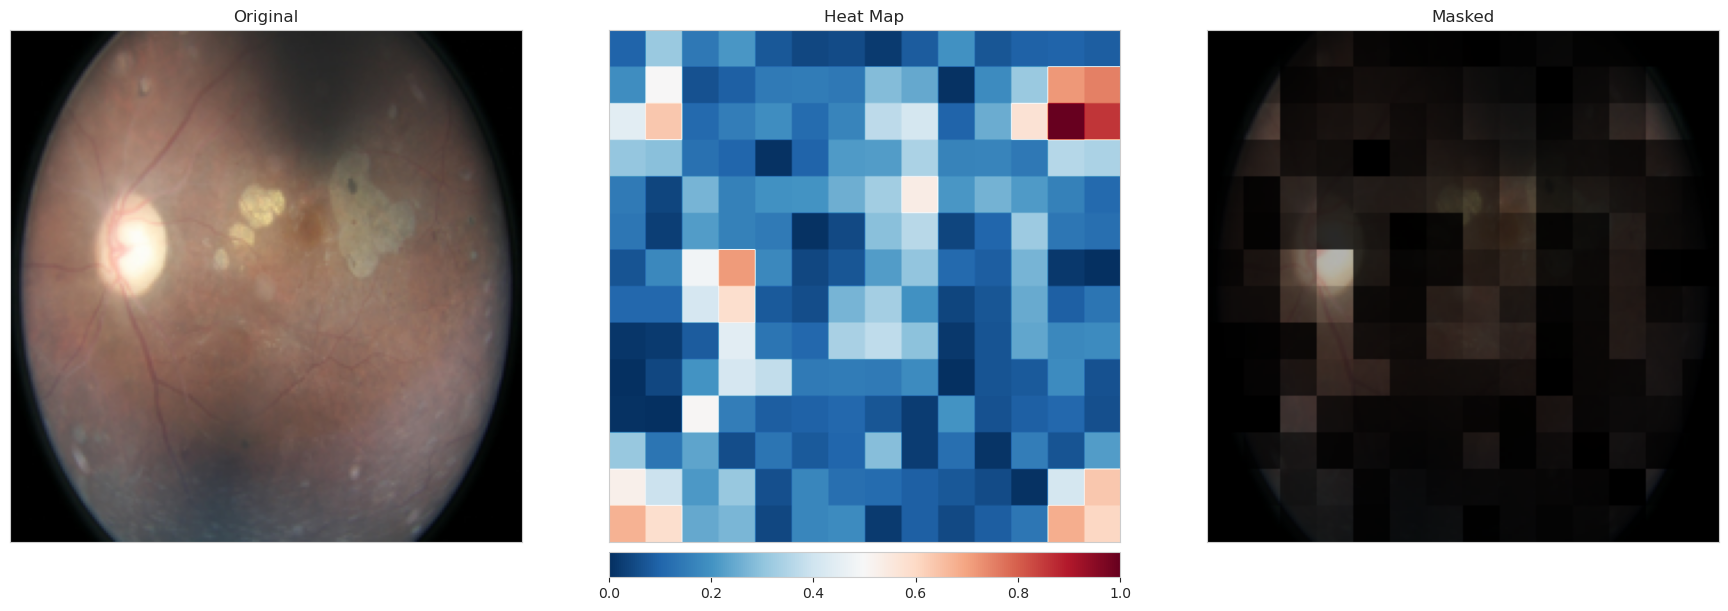

True class: 3
Predicted class: 3


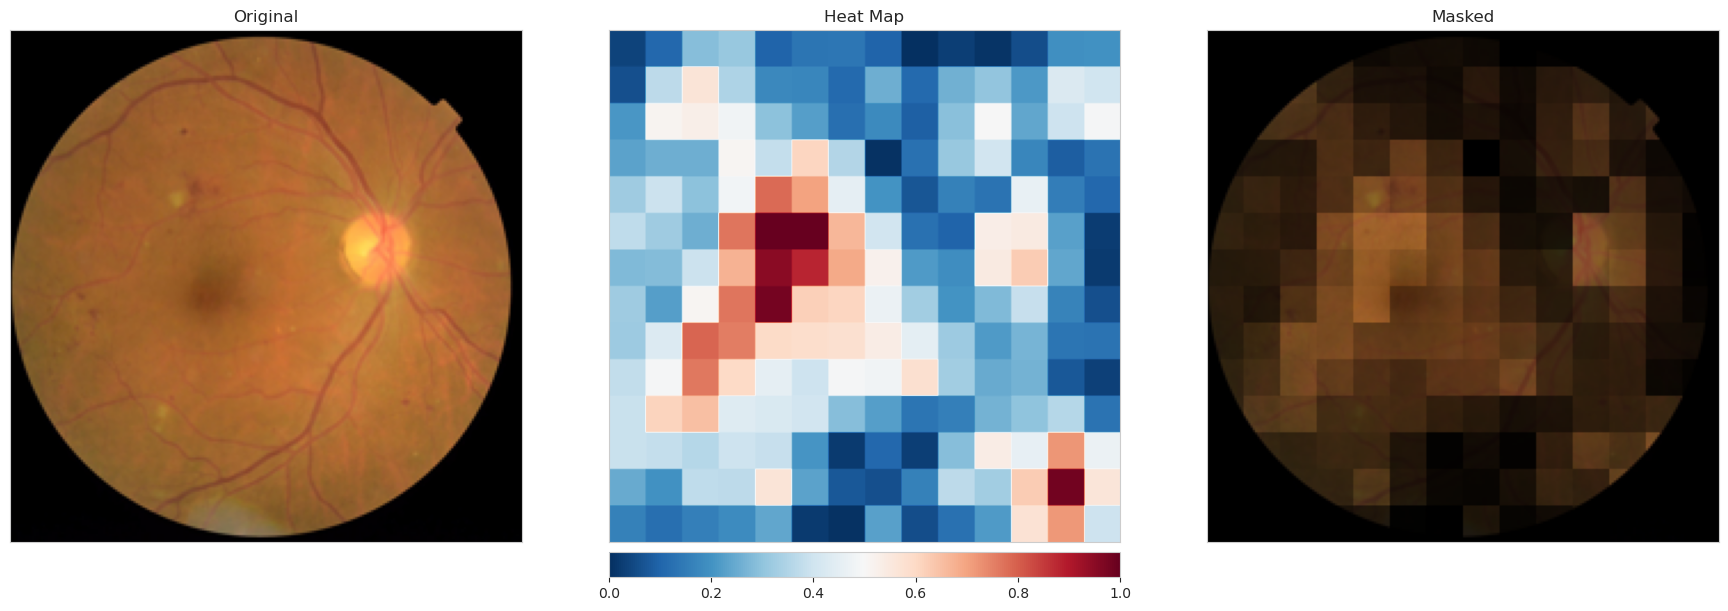

True class: 2
Predicted class: 0


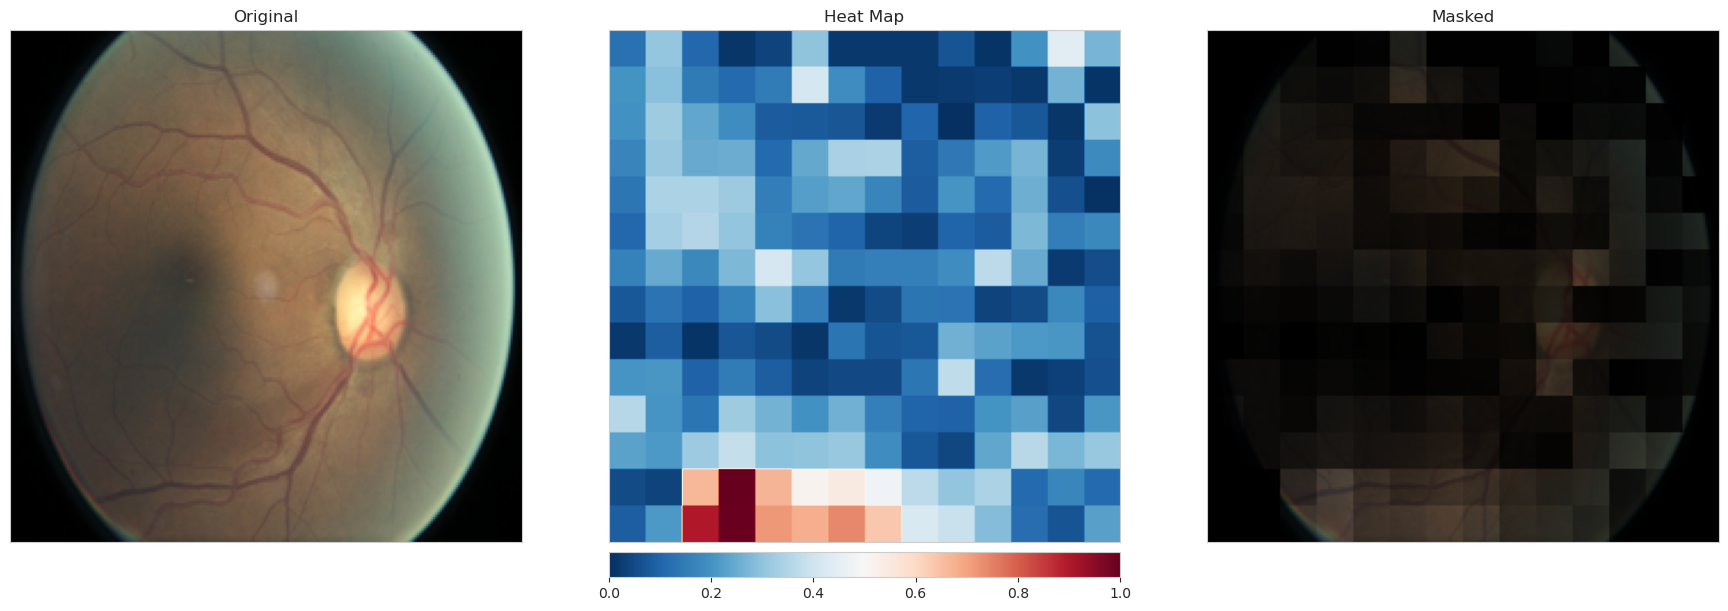

True class: 1
Predicted class: 1


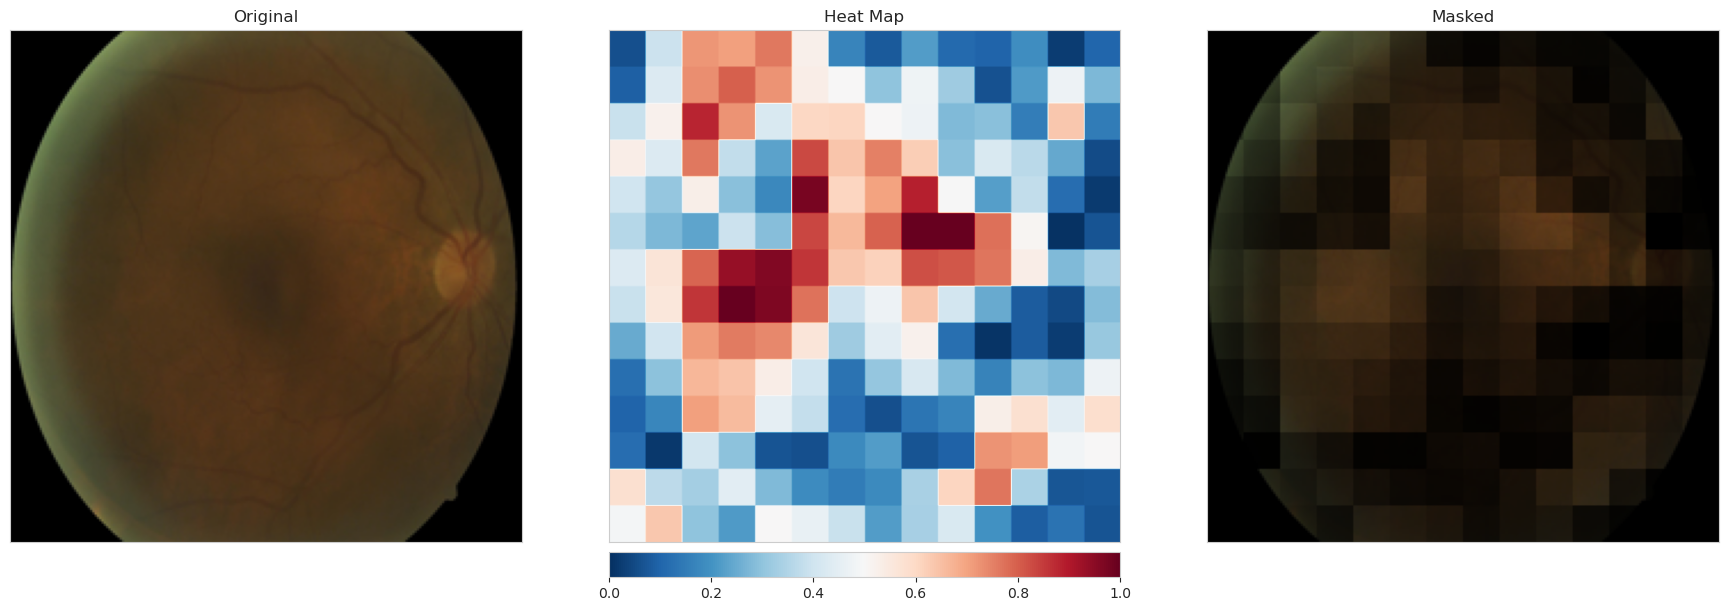

True class: 0
Predicted class: 1


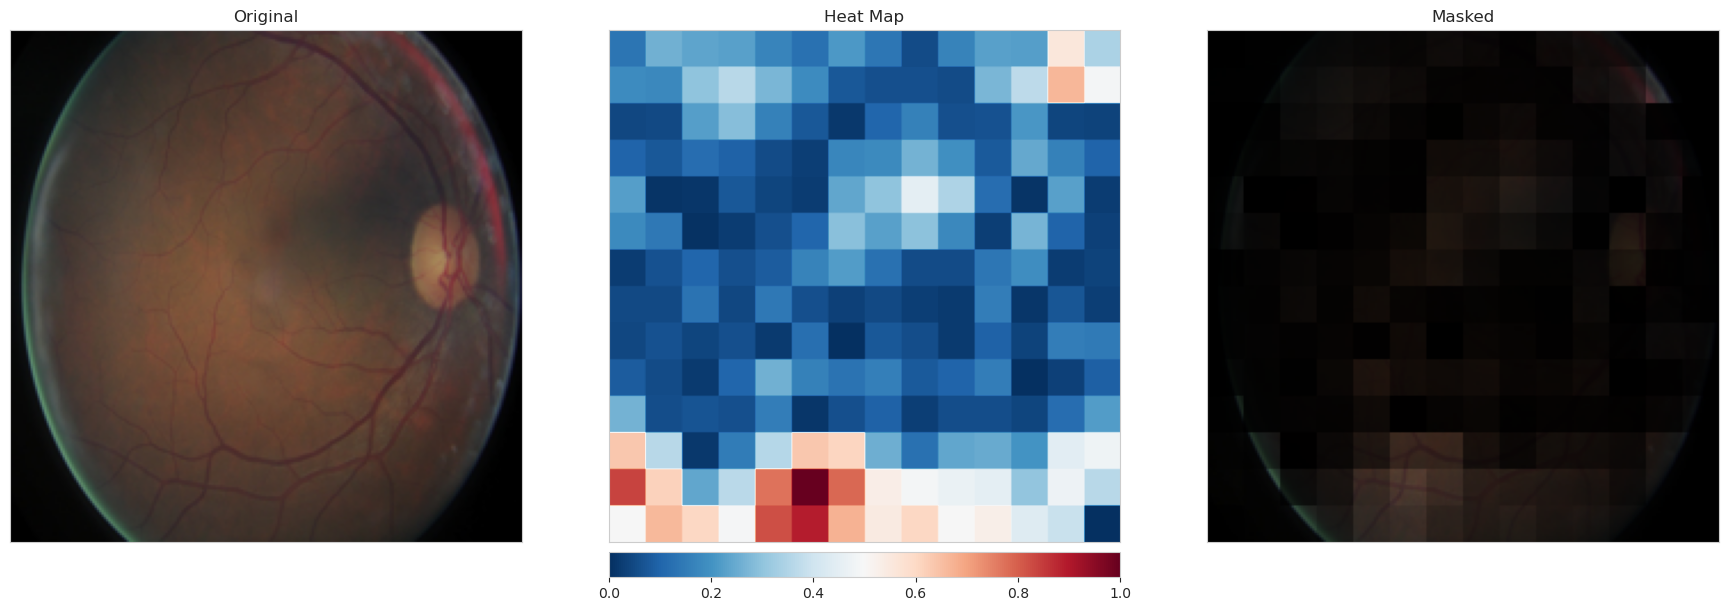

In [18]:
plot_attention_cnn(resnet.model, 50)

Class 4:
The model has only a light focus on the hard exudates of the eye which is an indicator of a diabetic retinopathy that is probably the most easy to see for a human.
It also has a focus on the optic disk 
Class 3:
Here, the model focusses mainly on a cotton wool spot, the macula and the optic disk.
Class 2:
The main focus lies on the optic disc and partly on the lower retinal arteries.
Class 1:
Its only focus lies on the macula which are not really considered to be biomarkers for a diabetic retinopathy.
Class 0:
The model focusses the lower retinal arteries which can be used to classify a healthy eye.

Generally, if biomarkers are visible, the model will focus on them to some extent and if no markers are visible, the model has no clear focus.

# 4.2 Big Transfer (BiT)
Big Transfer is an optimized ResNet which is made for the purpose of transfer learning. 
Transfer learning, as it was also done in the previous model, is also a technique to deal with little data, as most of the model weights are not trained and only the final layers are exchanged and trained to complete the desired task. 
## Training

It will say at some point "early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled", but early stopping does work like normal as can be seen in the training history plots.

In [19]:
model_name = "google/bit-50"
model = BitForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = BitImageProcessor.from_pretrained(model_name)

bit = HFTrainer(model, processor)

        
bit_history = bit.train(train_set=train_set,
          val_set=val_set,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="wandb",
          checkpoint_dir="./bit_checkpoints")


Some weights of BitForImageClassification were not initialized from the model checkpoint at google/bit-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([5, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/c/Users/mettn/Documents/repos/aaai_pose_estimation/project1/trainer.py:161: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
wandb: Currently logged in as: jmettner (gmllm). Use `wandb login --relogin` to force relogin


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find 

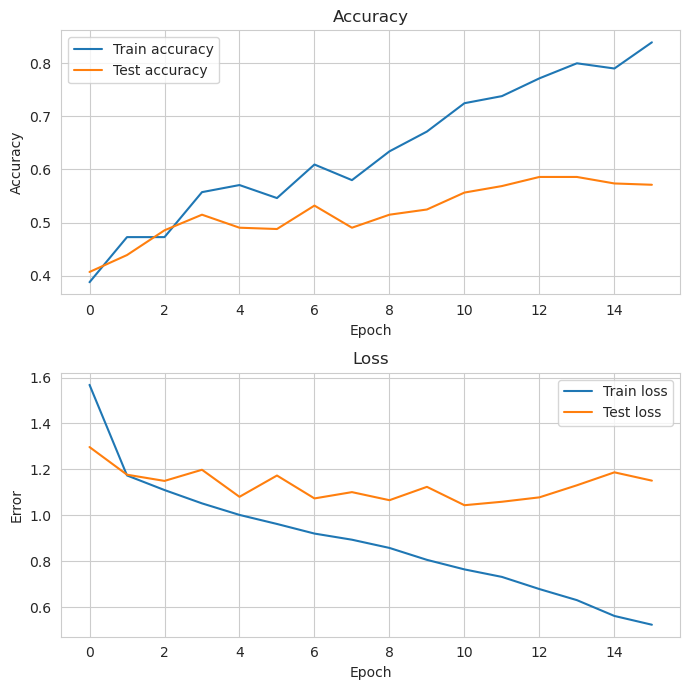

In [51]:
plot_history(bit_history)

The history looks similar to the one by the ResNet, just that the test accuracy is 14% higher for the validation set and the test loss is minimal at epoch 10.

## Evaluation
The model will be evaluated using the confusion matrix, the accuracy and the f1-score. Also the average inference time per image will be printed.

Average inference time per image is 15ms on the device NVIDIA GeForce RTX 3090 Ti.


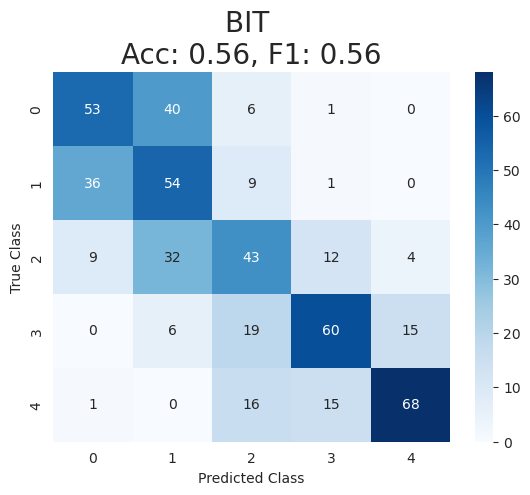

In [32]:
bit_labels, bit_preds = plot_confusion_matrix(bit, "BIT")

The accuracy and the F1 score are both 10 % higher than to the previous ResNet.
The model is now most of the time correct and only sometimes misses by one or two classes.

## Misclassified Images
Here, images are plotted that were not correctly classified by the model. For each image, the correct label and the prediction of the model will be presented.

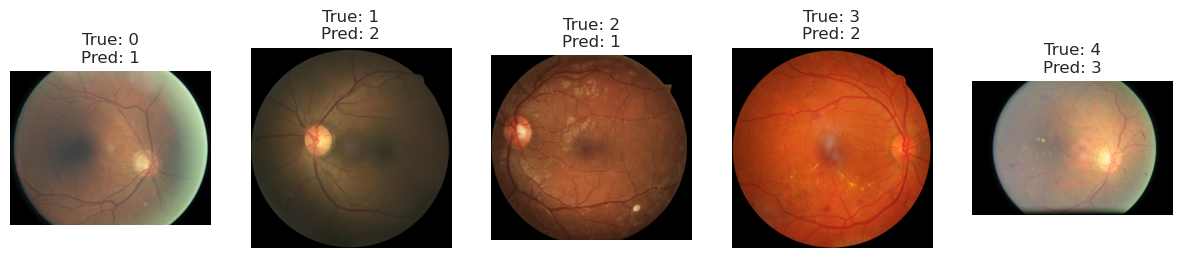

In [22]:
plot_misclassified(bit_labels, bit_preds)

Now, the model did not make any obvious errors and misses only by one class. The reasons for this are likely the same as for the previous model.

## Explainability
To explain the decision the model has made, the gradients from the convolution layers of the ResNet are extracted, visualized and plotted over the original image using the GradCam.
These gradients can be interpreted as heatmaps. Areas of the image that influenced the model the most are visualized in red and uninteresting areas in blue. 

True class: 4
Predicted class: 4


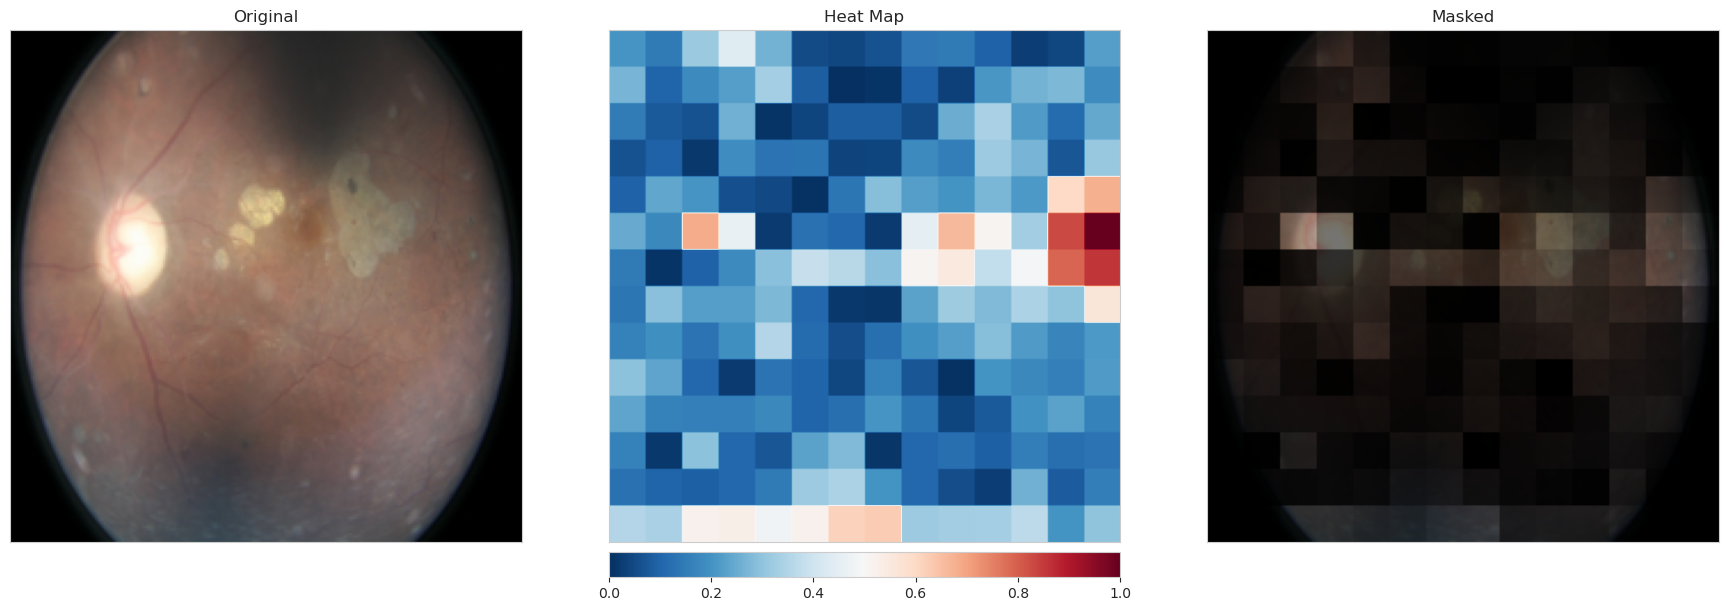

True class: 3
Predicted class: 3


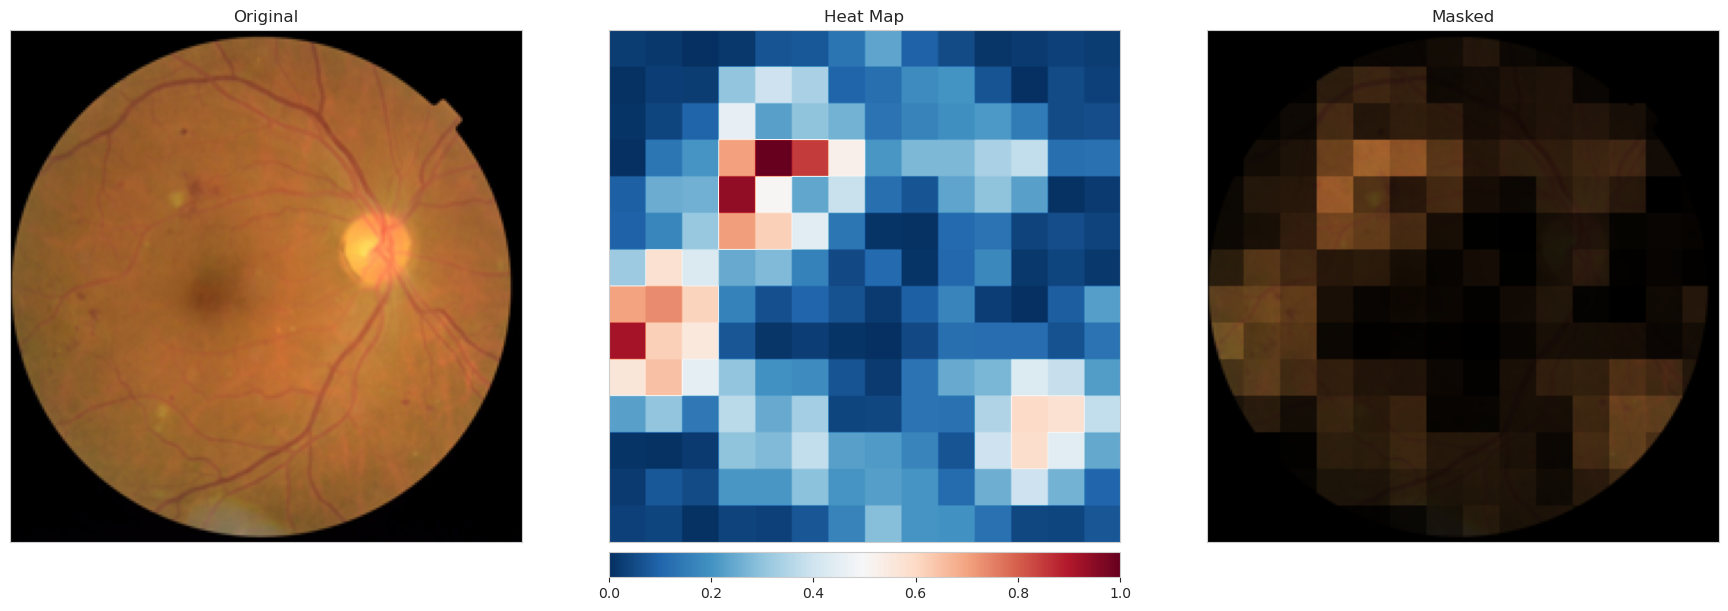

True class: 2
Predicted class: 1


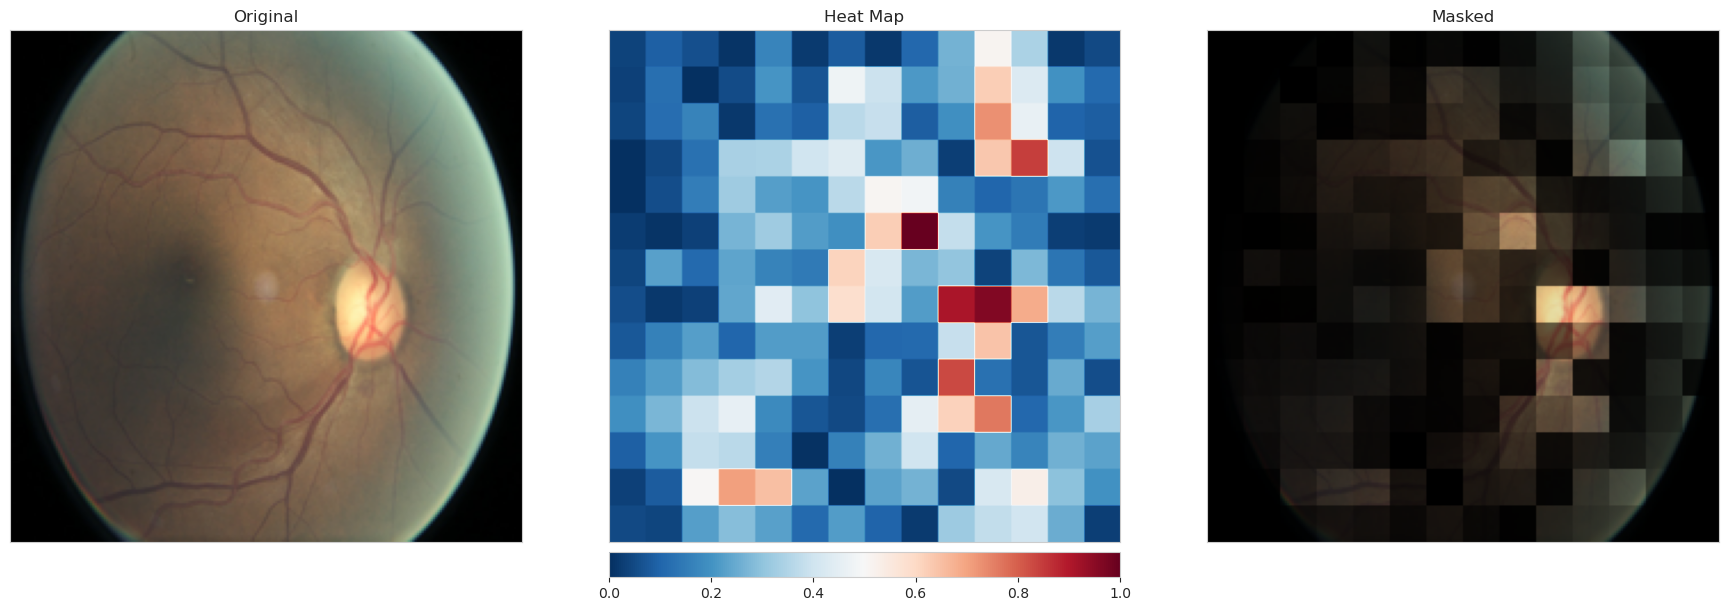

True class: 1
Predicted class: 1


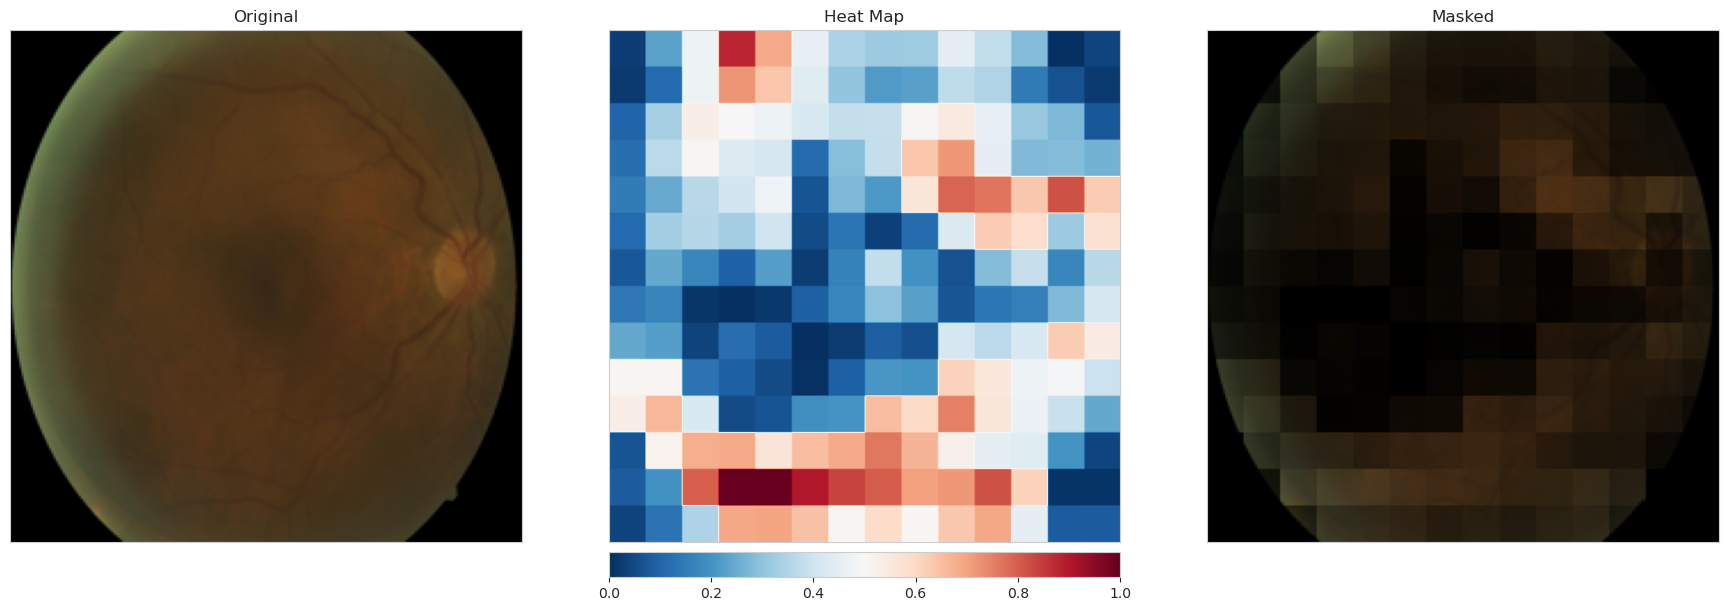

True class: 0
Predicted class: 1


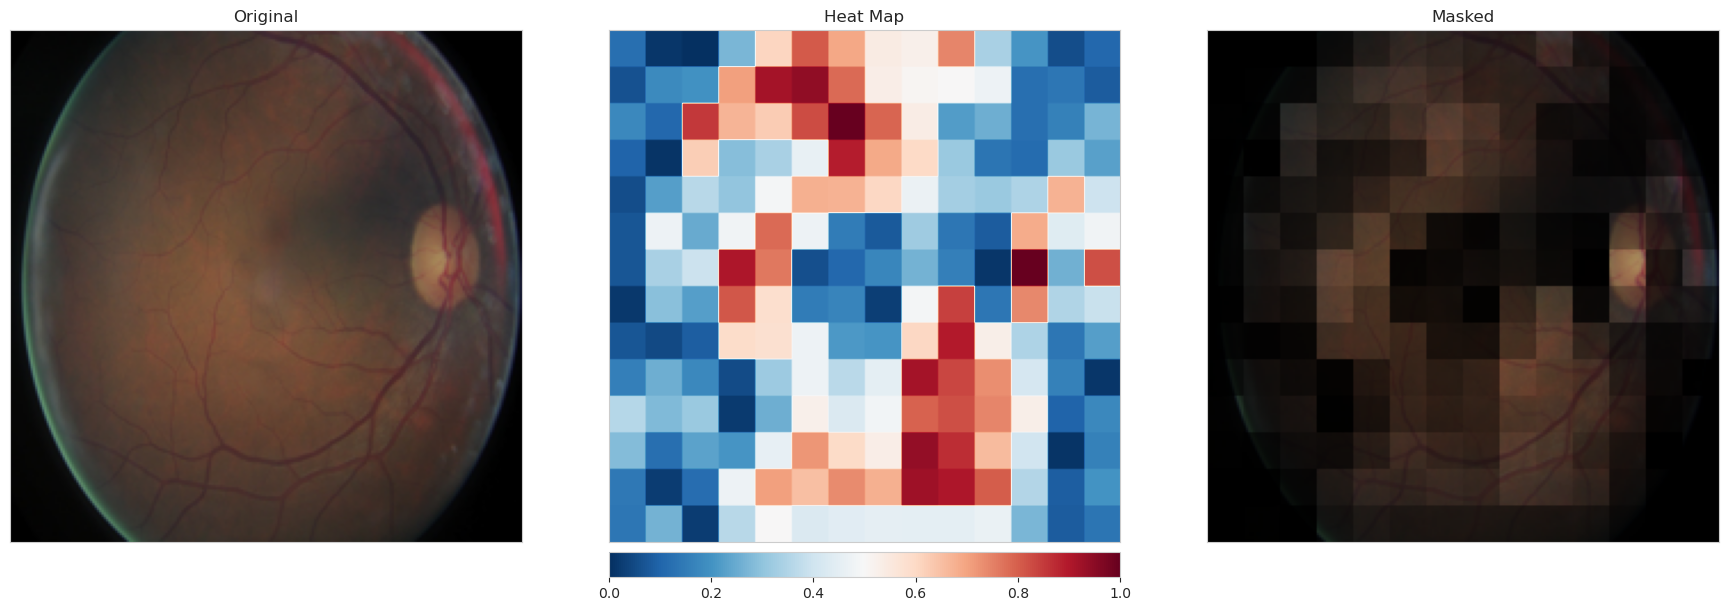

In [23]:
# Convert the model to a PyTorch module
class BitModelWrapper(torch.nn.Module):
    def __init__(self, bit_model):
        super(BitModelWrapper, self).__init__()
        self.bit_model = bit_model

    def forward(self, input_tensor):
        return self.bit_model(input_tensor).logits # The logits of the inference need to be returned

# Create an instance of the wrapper
bit_model_wrapper = BitModelWrapper(bit.model)
plot_attention_cnn(bit_model_wrapper, 30)

Class 4:
Now, the focus lies on the hard exudates, although not mainly. The optic disk and the right side of the eye are also focussed. The right side seems to contain many cotton wool spots.
Class 3:
Focussed are the retinal arteries and to some extend the two cotton wool spots. There also appear to be dot blot hemorrhage spots next to the upper cotton wool spot that the model focuses on.
Class 2:
Mostly the retinal arteries and a cotton wool spot are focussed by the model. The cotton wool spot is a clear indicator of a diabetic retinopathy.
Since no other biomarkers are visible, the model classified it with class 1.
Class 1:
The model focusses on the retinal arteries. When these look normal there is a high probability of the eye being healthy.
Class 0:
The same holds for this image, but additionally the optic disk is observed.

Generally, the model examines the retinal veins for more healthy eyes and cotton wool spots for unhealthy eyes.

# 4.2 Vision Transformer (ViT)
Developed in the paper "An Image is worth 16 x 16 words" by Google, this model is a repurposed natural language processing model and therefore, it is interesting to see how it competes with the established CNNs.
Other than the CNNs, all weight will be trained. Besides the base version, there are also the large and huge versions, which seemed to perform worse than the base version.
It may be that the base version is still to big for this task.

## Training

In [24]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_folder.class_to_idx),
    id2label=train_folder.class_to_idx,
    label2id={v: k for k, v in train_folder.class_to_idx.items()},
    ignore_mismatched_sizes=True
)
processor = ViTImageProcessor.from_pretrained(model_name)
vit = HFTrainer(model, processor)
vit_history = vit.train(train_set=train_set,
          val_set=val_set,
          bs=batch_size,
          epochs=30,
          lr=2e-4,
          patience=5,
          report_to="wandb",
          checkpoint_dir="./vit_checkpoints")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


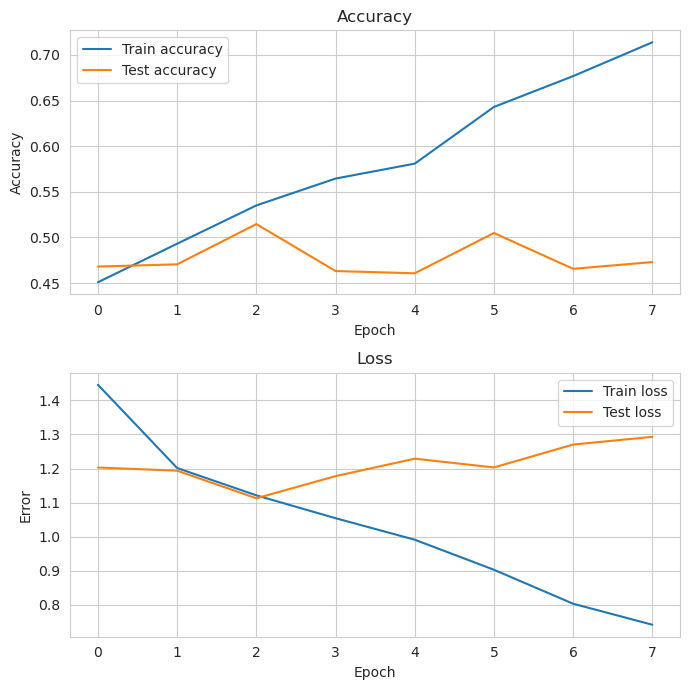

In [53]:
plot_history(vit_history)

The vision transformer is trained in less epochs than the ResNets with reaching their test loss minimum at epoch 2 already. The accuracy is lower than the one from the big transfer model.

## Evaluation
The model will be evaluated using the confusion matrix, the accuracy and the f1-score. Also the average inference time per image will be printed.

Average inference time per image is 15ms on the device NVIDIA GeForce RTX 3090 Ti.


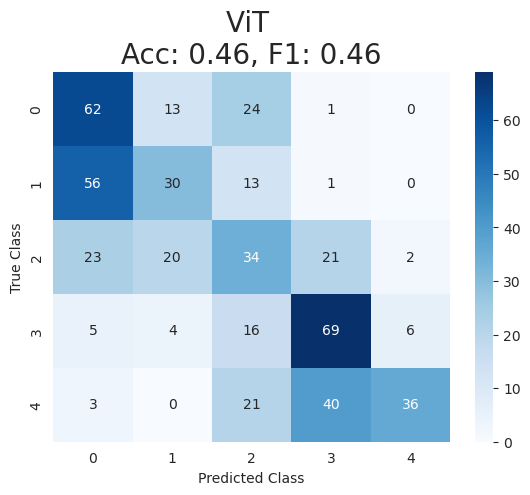

In [26]:
vit_labels, vit_preds = plot_confusion_matrix(vit, "ViT")

Like the first ResNet model, the vision transformer struggles to seperate classes 0 to 2, but unlike the first ResNet, it also cannot clearly differentiate between classes 2 to 4 resulting in the two "squares" in the top left and bottom right corner of the confusion matrix. It still achieves a similar accuracy and f1 score than the ResNet.

## Misclassified Images
Here, images are plotted that were not correctly classified by the model. For each image, the correct label and the prediction of the model will be presented.

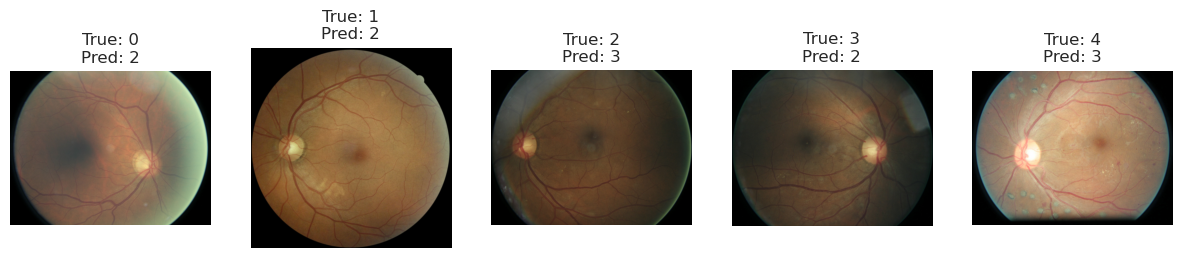

In [27]:
plot_misclassified(vit_labels, vit_preds)

These images are also indicating the difficulties of labeling such a dataset.

## Explainability
To explain the decision the model has made, the self attention matrices within the transformer are extracted and visualized.
These attention maps can also be interpreted as heatmaps. Areas of the image that influenced the model the most are visualized in red and uninteresting areas in blue.

Predicted class 4
True class 4


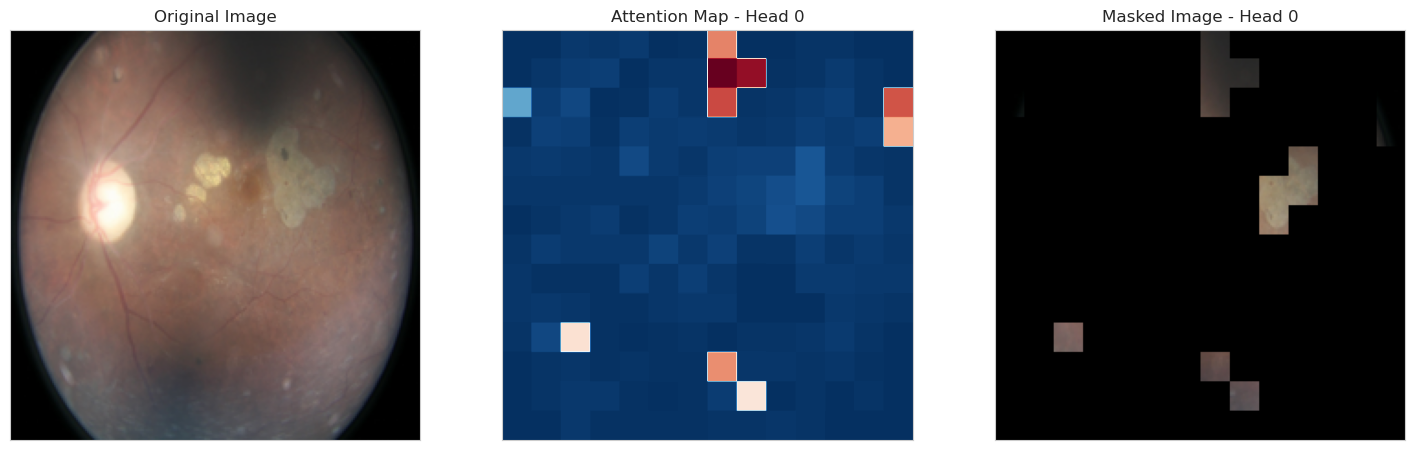

Predicted class 3
True class 3


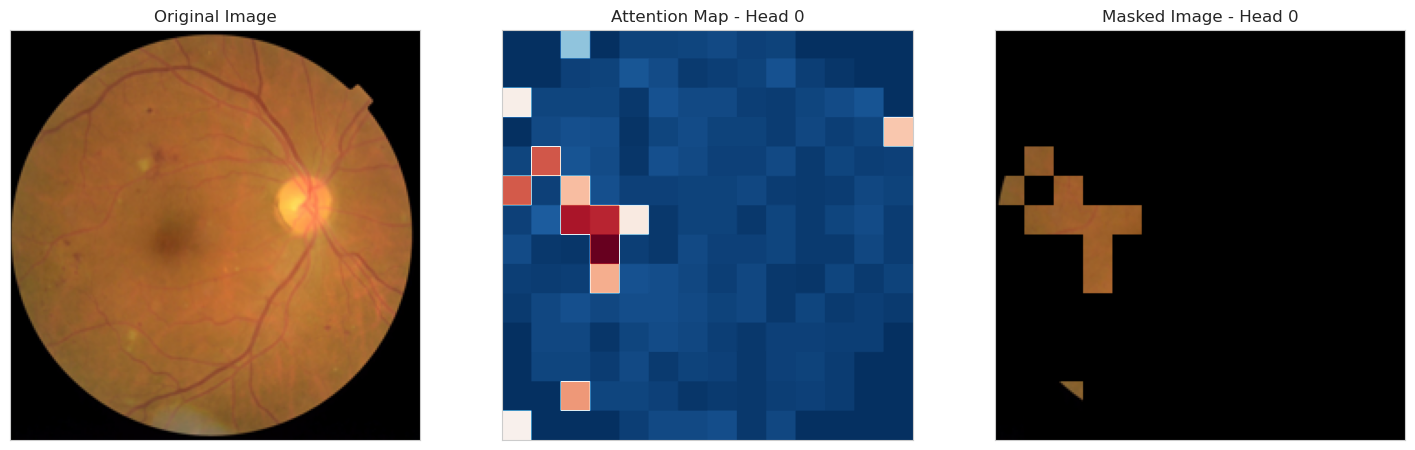

Predicted class 2
True class 2


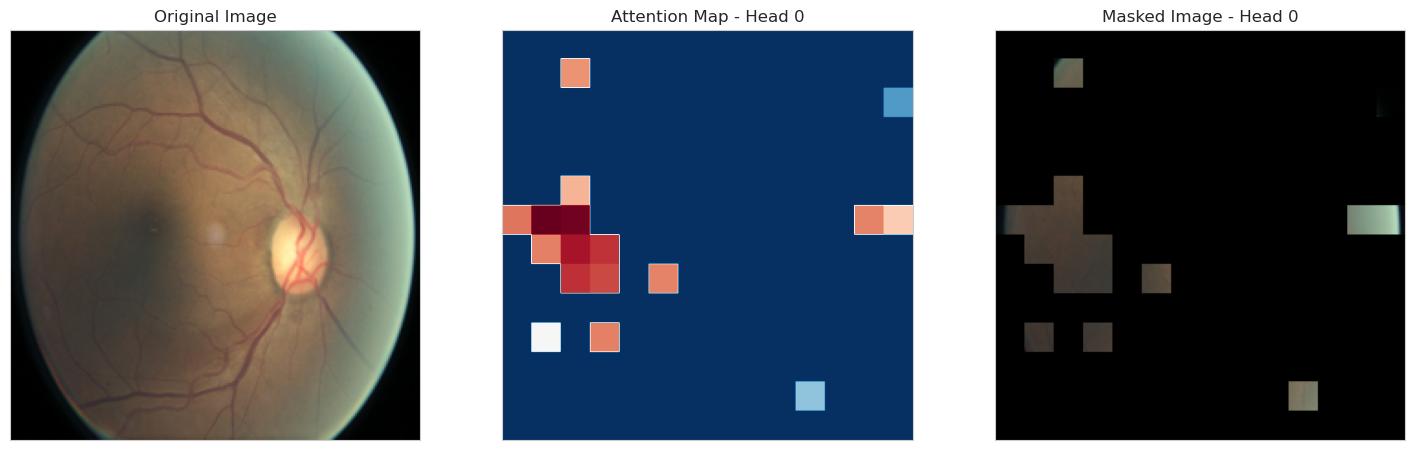

Predicted class 0
True class 1


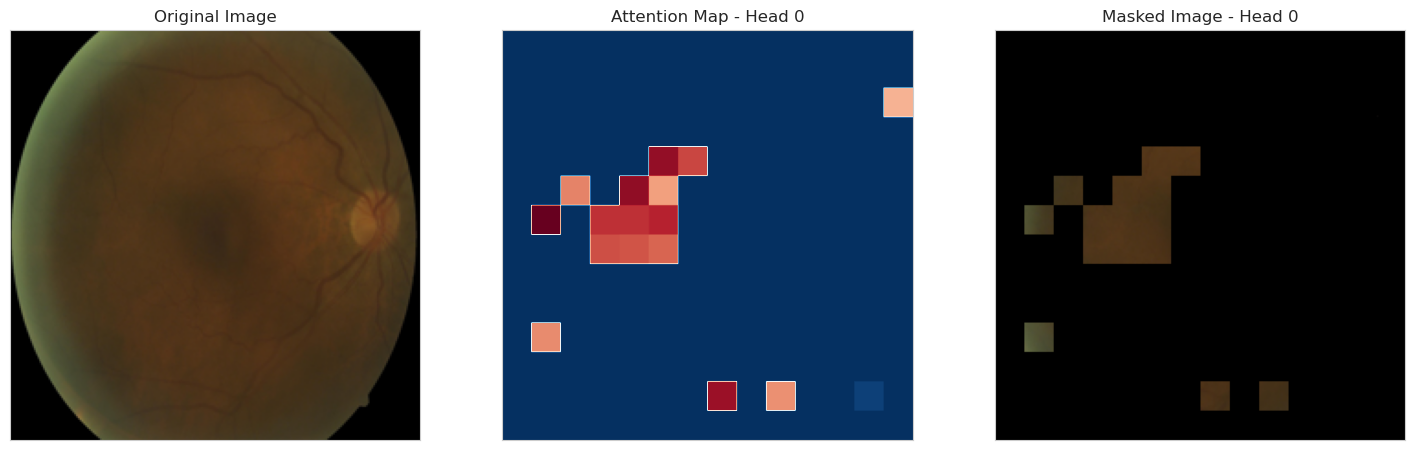

Predicted class 0
True class 0


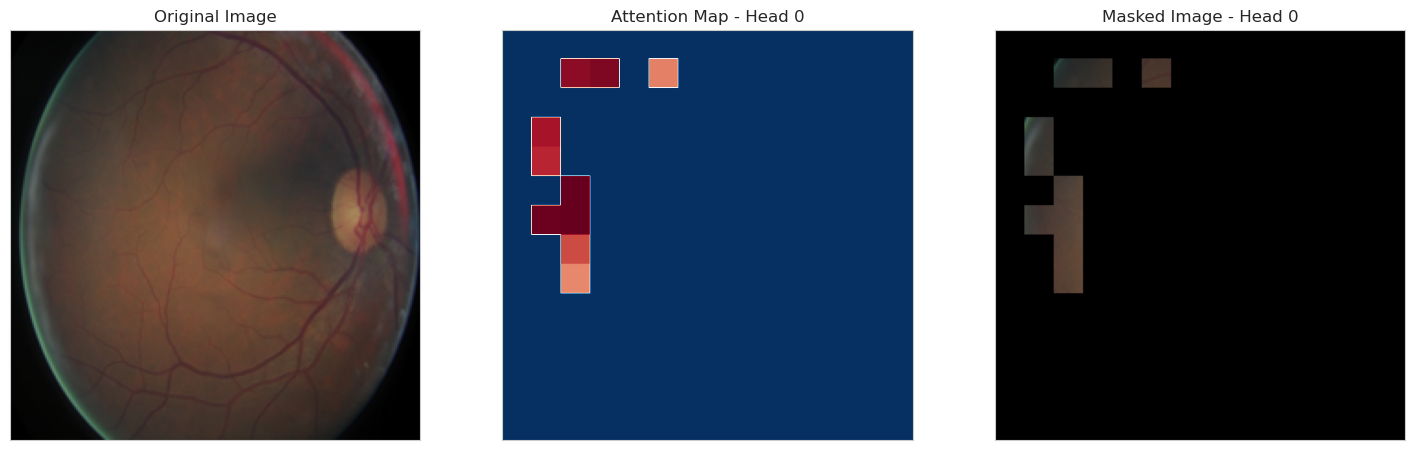

In [49]:
plot_attention_vit(vit.model, layer=-1, head=0, mask_threshold=0.005)

The attention maps do not show any relevant features except the first image where the hard exudates are focussed. But this may just be by chance.

# 5. Conclusion
The best performing model is the big transfer model with an accuracy and f1 score of 0.56. It is also the model that seems to be the most explainable, and it manages to confidently differentiate between the five classes. Most of the time it misses the correct class by only one class which is probably also due to the labeling difficulties that arise with labeling image data by a group of subjectively deciding individuals.
The recently advanced transformer architecture did not perform as good on this task, although it performs better on classifying imagenet images.

The biomarkers IRMA, retinal neovascularization and micro aneurysm are probably too small or are not visible at this down scaled resolution of the image to be detected by the models. At least the heat maps do not clearly focus them, and they are not visible to the untrained eye.
